# overview
Here,i plot the data dervied from the 7 networks, extracted in `scripts/step04_SPM/6cond_highlowcue_rampupplateau/s08_Buckner.mlx`
I plan to plot it in a bargraph with differing levels of colors and width

## 3 are the 7 network patterns similar across tasks for each participant?

In [121]:
from os.path import join
import pandas as pd
import numpy as np
import cmcrameri.cm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, plotting, datasets
from neuromaps import transforms
from neuromaps.datasets import fetch_fslr
from matplotlib.colors import LinearSegmentedColormap
from neuromaps.images import annot_to_gifti

## function

In [234]:
def plot_group_avg_proportions(dataframe, categories, colormap, significance_mask,figsize=(10, 1), title='Relative Proportions of Categories'):
    """
    Plot a single horizontal bar showing the relative proportions of specified categories based on their average values.

    Parameters:
    - dataframe: pd.DataFrame containing the data to plot.
    - categories: List of categories (columns in the dataframe) to plot.
    - colormap: A matplotlib colormap function to use for different categories.
    - figsize: Tuple indicating the figure size.
    - title: Title of the plot.
    """
    plt.rcParams['font.family'] = 'Arial'

    
    fig, ax = plt.subplots(figsize=figsize)
    # Calculate the average data across specified categories
    data = np.mean(dataframe[categories], axis=0)
    # Calculate relative proportions of the categories
    relative_proportions = np.abs(data) / np.sum(np.abs(data))
    
    # Generate colors from the provided colormap
    full_colors = colormap(np.linspace(0, 1, len(categories)))

        # Mute colors for non-significant categories
    # colors = [full_colors[i] if significance_mask[i] else (0.8, 0.8, 0.8) for i in range(len(categories))]
    colors = [(color[0], color[1], color[2], 0.2 if not significance_mask[i] else 1.0) for i, color in enumerate(full_colors)]
    
    
    # Plot each category proportion on top of the previous
    previous_value = 0
    for i, (color, prop) in enumerate(zip(colors, relative_proportions)):
        ax.barh('Proportions', prop, color=color, left=previous_value, edgecolor='white')
        previous_value += prop
    ax.set_ylim(-0.3, 0.3)
    # Add legend and set plot parameters
    ax.set_xlim(0, 1)
    ax.legend(categories, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Proportion of Total')
    ax.set_title(title)
    ax.set_yticks([])
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()


In [65]:
def plot_proportions(dataframe, categories, colormap, figsize=(10, 15)):
    """
    Plot a sorted bar chart of proportions of categories for each row in the dataframe.

    Parameters:
    - dataframe: pd.DataFrame containing the data to plot.
    - categories: List of categories (columns in the dataframe) to plot.
    - colormap: A matplotlib colormap to use for different categories.
    - figsize: Tuple indicating the figure size.
    """
    # Ensure that only numeric data is used
    # numeric_df = dataframe[categories].select_dtypes(include=[np.number])
    
    # Apply absolute value to ensure proportions are calculated from magnitudes
    # numeric_df = numeric_df.abs()
    
    # Sort the DataFrame based on the 'Frontoparietal' magnitude
    # numeric_df = numeric_df.sort_values(by='Frontoparietal', ascending=False)
    
    plt.figure(figsize=figsize)
    
    # Generate colors from the provided colormap
    colors = colormap(np.linspace(0, 1, len(categories)))
    
    # Plot the proportions for each subject
    for idx, row in dataframe.iterrows():
        # Calculate the proportion of each category in the row
        row_proportions = row / row.sum()
        previous_value = 0
        for i, prop in enumerate(row_proportions):
            plt.barh(idx, prop, color=colors[i], left=previous_value, edgecolor='white')
            previous_value += prop
    
    # Set plot parameters
    plt.xlim(0, 1)
    plt.legend(categories, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Proportion of Total')
    plt.title('Relative Proportions of Categories for Each Subject')
    # plt.yticks(range(len(dataframe)), ['Subject ' + str(i+1) for i in dataframe.index])

    plt.show()


In [113]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(5000, 1000), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior', 'dorsal'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


# plot Yeo 7 networks

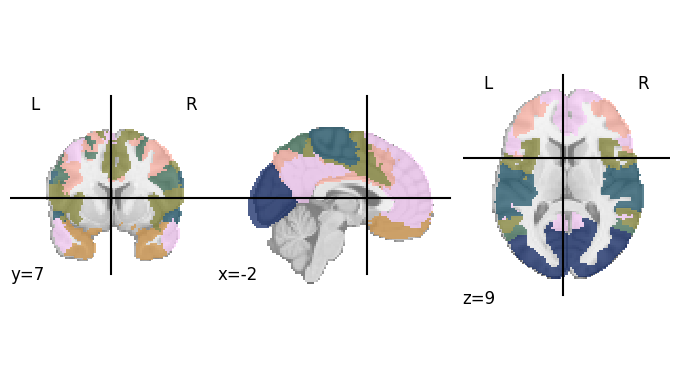

In [157]:
buckner = image.load_img('./Buckner_Parcellation_7network.nii')
standard_brain = datasets.load_mni152_template(resolution=2)
resampled_buckner = image.resample_to_img(buckner, standard_brain, interpolation='nearest')

categories = ['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default']
# mni __________________________________________________________________________
batlow_colors = ccm.batlow(np.linspace(0, 1, len(categories) + 1))[1:]  # Skip the first color
batlow_cmap = LinearSegmentedColormap.from_list("batlow_custom", batlow_colors, N=len(batlow_colors))

# Use the custom colormap in the plotting function
# plotting.plot_roi(resampled_buckner, cmap=batlow_cmap)
batlow_colors = ccm.batlow(np.linspace(0, 1, 8))
plotting.plot_roi(buckner, cmap=ccm.batlow)#ccm.batlow)



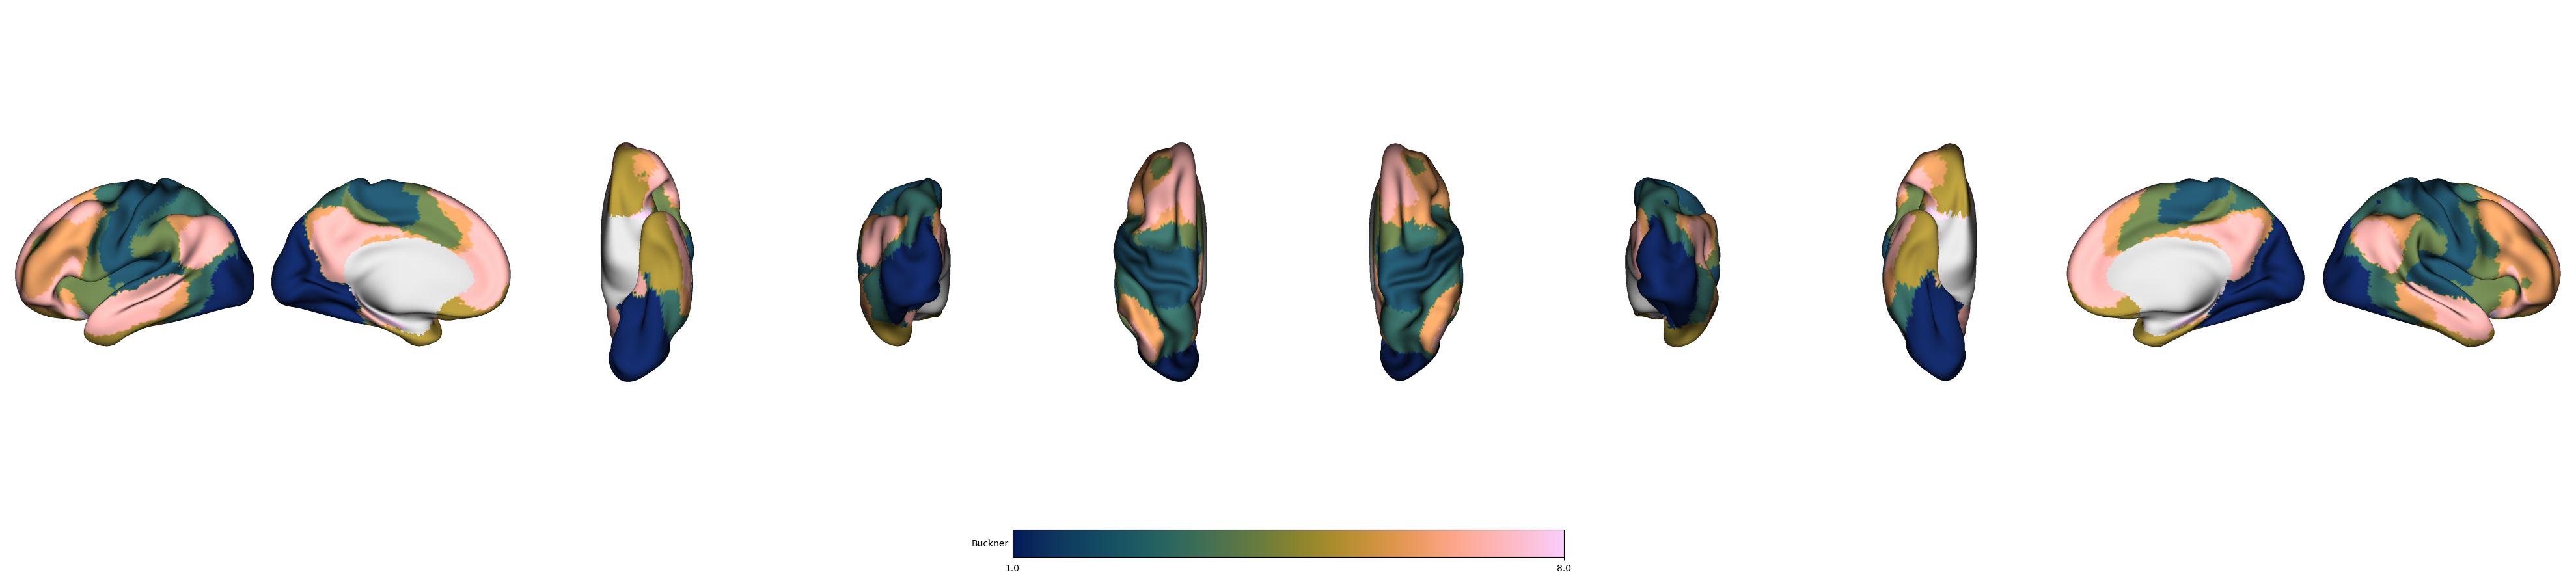

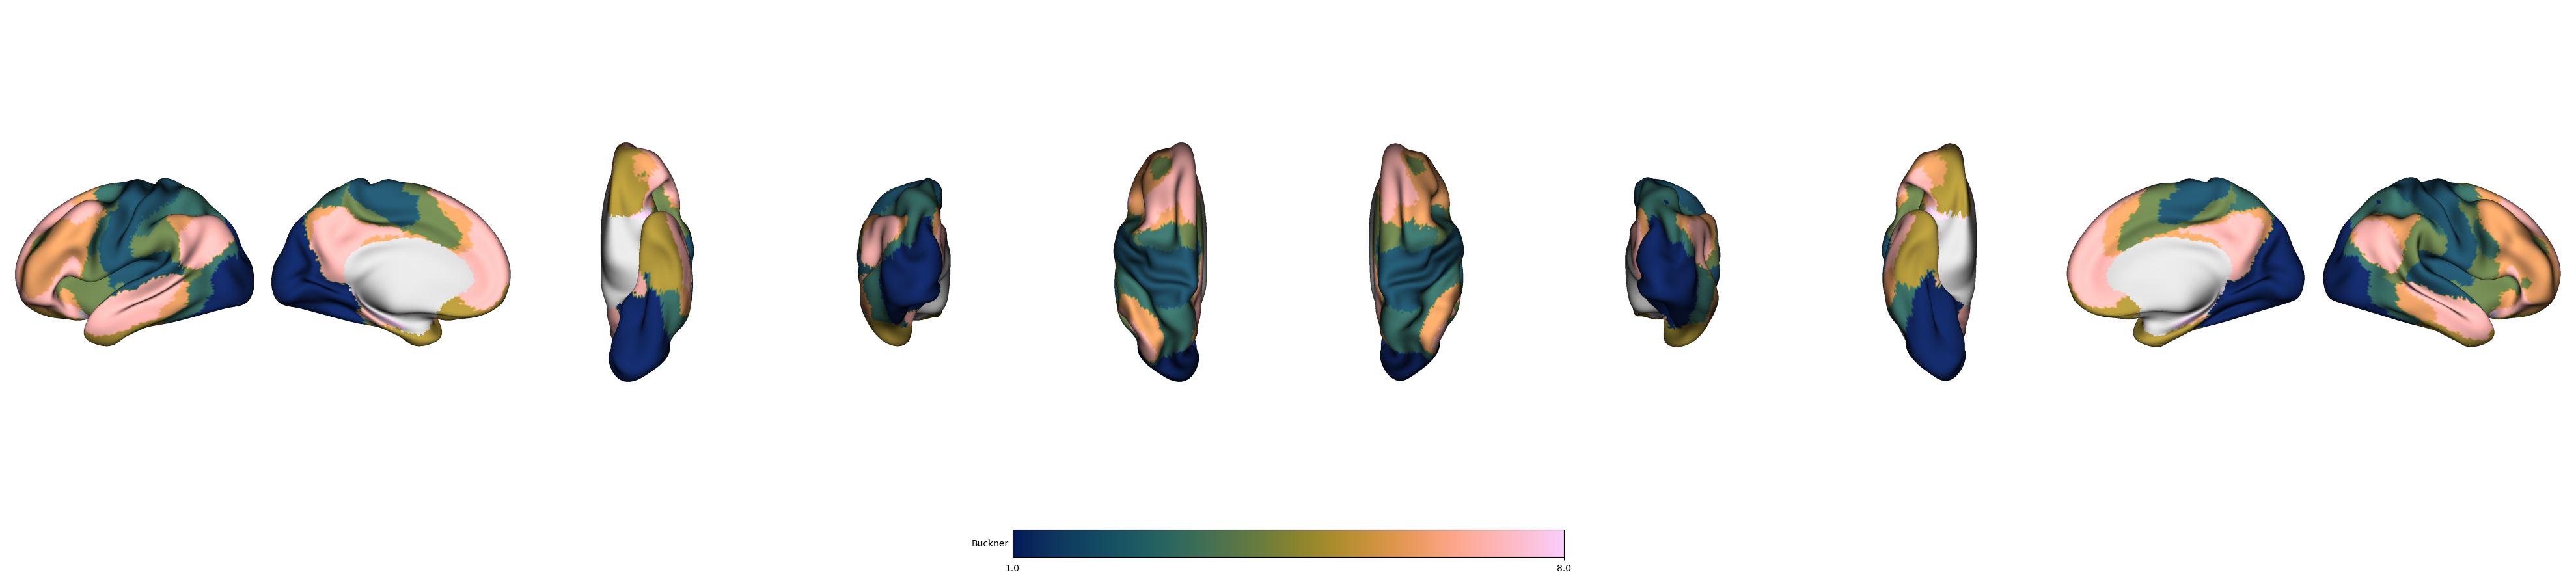

In [158]:
yeolh = annot_to_gifti('./fsaverage6/label/lh.Yeo2011_7Networks_N1000.annot')
yeorh = annot_to_gifti('./fsaverage6/label/rh.Yeo2011_7Networks_N1000.annot')
yeo_fslr_lh = transforms.fsaverage_to_fslr(yeolh, hemi='L', target_density='32k', method='nearest')
yeo_fslr_rh = transforms.fsaverage_to_fslr(yeorh, hemi='R', target_density='32k', method='nearest')

yeo = (yeo_fslr_lh[0], yeo_fslr_rh[0])

plot_brain_surfaces(yeo, cbar_label='Buckner', cmap=ccm.batlow)

In [87]:
# load files
result_dir = '/Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/spm/univariate/model01_6cond_highlowcue_rampplateau/Buckner'
P_STIM_cue_fname = join(result_dir, 'buckner_P_simple_STIM_cue_high_gt_low.csv')
V_STIM_cue_fname = join(result_dir, 'buckner_V_simple_STIM_cue_high_gt_low.csv')
C_STIM_cue_fname = join(result_dir, 'buckner_C_simple_STIM_cue_high_gt_low.csv')

P_STIM_cue = pd.read_csv(P_STIM_cue_fname)
V_STIM_cue = pd.read_csv(V_STIM_cue_fname)
C_STIM_cue = pd.read_csv(C_STIM_cue_fname)

In [179]:
df = pd.concat([P_STIM_cue, V_STIM_cue, C_STIM_cue])

In [182]:
df

,Visual,Somatomotor,dAttention,vAttention,Limbic,Frontoparietal,Default,task,sub
0,0.419957,-0.082470,0.242272,0.339013,-0.075874,0.585041,0.532729,pain,1
1,-0.072396,0.247996,-0.309273,0.193757,-0.261022,-0.448268,-0.064188,pain,2
2,-0.835108,-1.016108,-0.516990,-0.882225,-0.169756,0.109128,-0.119690,pain,3
3,-0.337433,0.267792,0.089877,0.619298,-0.284622,0.169074,-0.225212,pain,4
4,-0.261014,0.269992,0.276118,0.274956,-0.111801,0.776628,0.203549,pain,5
...,...,...,...,...,...,...,...,...,...
87,-0.151266,0.317183,-0.220661,0.394859,0.236963,-0.103303,0.488421,cognitive,88
88,0.630870,0.255826,0.253594,0.310196,0.113978,0.045870,0.149119,cognitive,89
89,0.771235,0.377114,0.950398,0.572620,0.132441,0.652180,0.171299,cognitive,90
90,-0.765147,-0.700924,-0.401368,-0.806275,-0.570392,-0.650521,-0.884927,cognitive,91


In [184]:
df_wide = df.melt(id_vars=['sub', 'task'],
                  value_vars=[ 'Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                  var_name='network', value_name='value')
df_wide

,sub,task,network,value
0,1,pain,Visual,0.419957
1,2,pain,Visual,-0.072396
2,3,pain,Visual,-0.835108
3,4,pain,Visual,-0.337433
4,5,pain,Visual,-0.261014
...,...,...,...,...
1927,88,cognitive,Default,0.488421
1928,89,cognitive,Default,0.149119
1929,90,cognitive,Default,0.171299
1930,91,cognitive,Default,-0.884927


## 2 are neural cue effects correlated with behavioral cue effects?

In [207]:
# # Assuming the structure of the DataFrame 'df' is as follows:
# # sub | task  | Visual | Somatomotor | dAttention | vAttention | Limbic | Frontoparietal | Default
# # -------------------------------------------------------------------------------------------
# # 1   | Pain  | value  | value       | value      | value      | value  | value          | value
# # 1   | Cognitive | value  | value       | value      | value      | value  | value          | value
# # ...

# # First, let's filter out only the rows for the Pain and Cognitive tasks
# pain_cognitive_df = df[df['task'].isin(['pain', 'cognitive'])]

# # Now pivot this DataFrame so that we have one row per subject with pain and cognitive values side by side
# pivot_df = pain_cognitive_df.pivot(index='sub', columns='task')

# # We don't need a MultiIndex in the columns, so let's flatten that
# pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# # Now calculate the within-subject correlation between pain and cognitive tasks
# # for each subject across all 7 values
# correlation_results = {}
# for sub in pivot_df.index:
#     # Select the pain and cognitive values for this subject
#     pain_values = pivot_df.loc[sub, [col for col in pivot_df if 'pain' in col]]
#     cognitive_values = pivot_df.loc[sub, [col for col in pivot_df if 'cognitive' in col]]
#     # Calculate the correlation for this subject
#     correlation = np.corrcoef(pain_values, cognitive_values)[0, 1]
#     correlation_results[sub] = correlation

# # Convert to a DataFrame for easier handling
# correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation'])

# # Show the results
# print(correlation_df)


import pandas as pd
import numpy as np

# Assuming the DataFrame 'df' has the following structure:
# sub | task        | Visual | Somatomotor | dAttention | vAttention | Limbic | Frontoparietal | Default
# -----------------------------------------------------------------------------------------------------
# 1   | Pain        | value  | value       | value      | value      | value  | value          | value
# 1   | Cognitive   | value  | value       | value      | value      | value  | value          | value
# 1   | Vicarious   | value  | value       | value      | value      | value  | value          | value
# ...

def calculate_task_correlations(df, task1, task2):
    # Filter only the rows for the two tasks
    filtered_df = df[df['task'].isin([task1, task2])]

    # Pivot DataFrame so that we have one row per subject with task1 and task2 values side by side
    pivot_df = filtered_df.pivot(index='sub', columns='task')
    # Flatten the MultiIndex in the columns
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

    # Calculate the within-subject correlation between task1 and task2 for each subject across all 7 values
    correlation_results = {}
    for sub in pivot_df.index:
        # Select the values for task1 and task2 for this subject
        task1_values = pivot_df.loc[sub, [col for col in pivot_df if task1 in col]]
        task2_values = pivot_df.loc[sub, [col for col in pivot_df if task2 in col]]
        # Calculate the correlation for this subject
        correlation = np.corrcoef(task1_values, task2_values)[0, 1]
        correlation_results[sub] = correlation

    return pd.DataFrame.from_dict(correlation_results, orient='index', columns=[f'{task1}-{task2} Correlation'])

# Specify the tasks to compare
task_pairs = [
    ('pain', 'cognitive'),
    ('pain', 'vicarious'),
    ('cognitive', 'vicarious')
]

# Compute correlations for each task pair
correlation_dfs = [calculate_task_correlations(df, task1, task2) for task1, task2 in task_pairs]

# Combine the results into a single DataFrame
final_correlation_df = pd.concat(correlation_dfs, axis=1)

# Print or return the results
print(final_correlation_df)



    pain-cognitive Correlation  pain-vicarious Correlation  \
1                     0.643172                   -0.259538   
2                    -0.828948                   -0.118189   
3                    -0.558777                   -0.040954   
4                     0.645416                   -0.153554   
5                     0.224989                   -0.334427   
..                         ...                         ...   
88                    0.328090                   -0.540142   
89                   -0.114364                   -0.284164   
90                   -0.329397                   -0.194448   
91                   -0.394207                    0.056031   
92                    0.252494                    0.579052   

    cognitive-vicarious Correlation  
1                          0.247091  
2                          0.260373  
3                         -0.467169  
4                         -0.454379  
5                          0.243497  
..                         

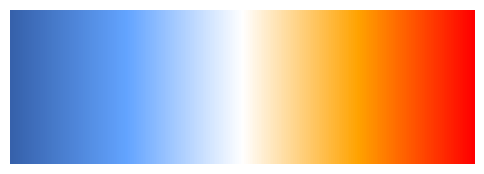

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# Define the colors with specified opacities
colors_with_opacity = [
    (-0.015, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.0005, to_rgba("#63a4ff", alpha=1)),    # Fully opaque
    (0, to_rgba("white", alpha=1)),          # Transparent
    (0.0005, to_rgba("#ffa300", alpha=1)),    # Fully opaque
    (0.015, to_rgba("#ff0000", alpha=1.0))   # Fully opaque
]

# Normalize the points to the [0, 1] interval and prepare the colors for the colormap
norm_points = np.linspace(-0.045, 0.045, len(colors_with_opacity))
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())
norm_colors = [c[1] for c in colors_with_opacity]

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient to visualize the colormap
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


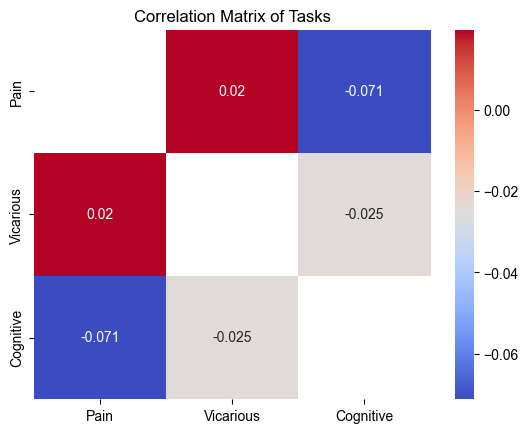

In [266]:
final_correlation_df.mean()

corr_pain_cognitive = final_correlation_df.mean()['pain-cognitive Correlation']
corr_pain_vicarious = final_correlation_df.mean()['pain-vicarious Correlation']
corr_cognitive_vicarious = final_correlation_df.mean()['cognitive-vicarious Correlation']

# Create a correlation matrix
correlation_matrix = [
    [np.nan, corr_pain_vicarious, corr_pain_cognitive ],
    [corr_pain_vicarious, np.nan, corr_cognitive_vicarious],
    [corr_pain_cognitive, corr_cognitive_vicarious, np.nan]
]

# Define the task labels
tasks = ['Pain', 'Vicarious', 'Cognitive']
# Plot the correlation matrix as a heatmap
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
mask = np.eye(len(correlation_matrix), dtype=bool)

# sns.heatmap(correlation_matrix, annot=True, 
#             mask=mask,
#             cmap='coolwarm',#ccm.batlow, 
#             xticklabels=tasks, yticklabels=tasks)

mask = np.eye(len(correlation_matrix), dtype=bool)

# Plot the correlation matrix as a heatmap, showing annotations on the diagonal with '1' and no color fill for them
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask,
            xticklabels=tasks, yticklabels=tasks, cbar=True)#, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Tasks')
plt.show()

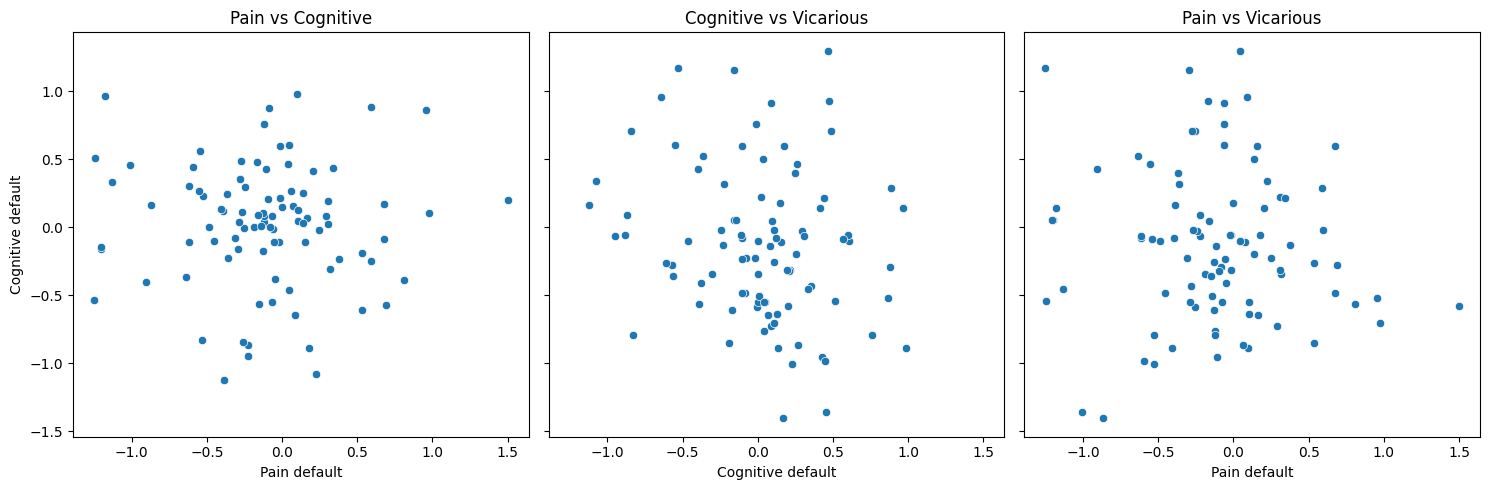

In [209]:
# Pivot the DataFrame to get tasks as columns
pivot_df = df.pivot(index='sub', columns='task', values='Default')

# Plotting the scatter plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
tasks = ['pain', 'cognitive', 'vicarious']
pairs = [('pain', 'cognitive'), ('cognitive', 'vicarious'), ('pain', 'vicarious')]

for i, (task1, task2) in enumerate(pairs):
    sns.scatterplot(x=pivot_df[task1], y=pivot_df[task2], ax=ax[i])
    ax[i].set_title(f'{task1.capitalize()} vs {task2.capitalize()}')
    ax[i].set_xlabel(f'{task1.capitalize()} default')
    ax[i].set_ylabel(f'{task2.capitalize()} default')

plt.tight_layout()
plt.show()

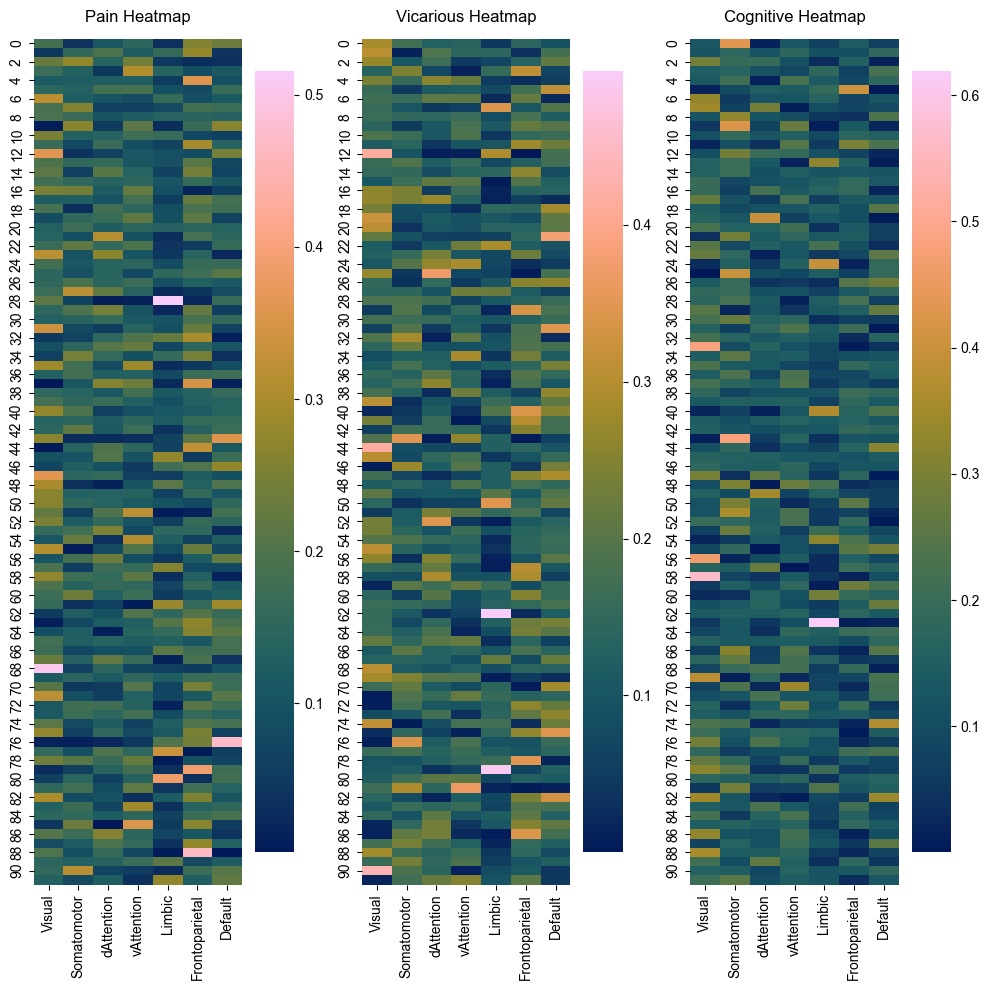

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'ccm.batlow' is a colormap you have access to
# and 'categories' is defined as ['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))  # Adjust figsize as needed

# First heatmap for P_STIM_cue
Pproportions = np.abs(P_STIM_cue[categories]).div(np.abs(P_STIM_cue[categories]).sum(axis=1), axis=0)
sns.heatmap(Pproportions, annot=False, fmt=".2f", cmap=ccm.batlow, ax=axes[0])
axes[0].set_title('Pain Heatmap', fontdict={'fontsize':12}, pad=12)

# Second heatmap for V_STIM_cue
Vproportions = np.abs(V_STIM_cue[categories]).div(np.abs(V_STIM_cue[categories]).sum(axis=1), axis=0)
sns.heatmap(Vproportions, annot=False, fmt=".2f", cmap=ccm.batlow, ax=axes[1])
axes[1].set_title('Vicarious Heatmap', fontdict={'fontsize':12}, pad=12)

# Third heatmap for C_STIM_cue
Cproportions = np.abs(C_STIM_cue[categories]).div(np.abs(C_STIM_cue[categories]).sum(axis=1), axis=0)
sns.heatmap(Cproportions, annot=False, fmt=".2f", cmap=ccm.batlow, ax=axes[2])
axes[2].set_title('Cognitive Heatmap', fontdict={'fontsize':12}, pad=12)

plt.tight_layout()
plt.show()


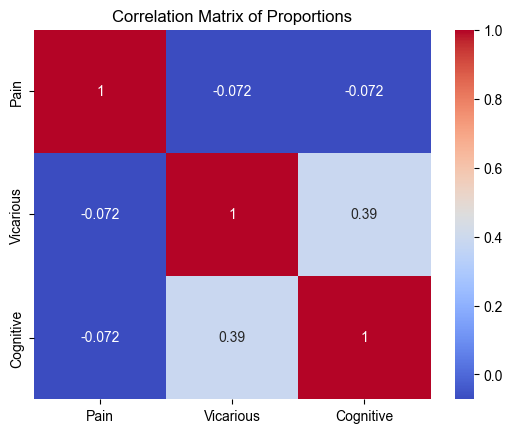

In [241]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have computed the proportions for each task as 2D NumPy arrays
# Pproportions, Vproportions, Cproportions = ...

# Calculate the correlation coefficients between each pair of tasks
corr_PC = np.corrcoef(Pproportions, Cproportions)[0, 1]
corr_VC = np.corrcoef(Vproportions, Cproportions)[0, 1]
corr_PV = np.corrcoef(Pproportions, Vproportions)[0, 1]
pain-cognitive Correlation        -0.071164
pain-vicarious Correlation         0.019670
cognitive-vicarious Correlation   -0.024541

# Create a correlation matrix
correlation_matrix = np.array([[1, corr_PV, corr_PC],
                               [corr_PV, 1, corr_VC],
                               [corr_PC, corr_VC, 1]])

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            xticklabels=['Pain', 'Vicarious', 'Cognitive'],
            yticklabels=['Pain', 'Vicarious', 'Cognitive'])
plt.title('Correlation Matrix of Proportions')
plt.show()


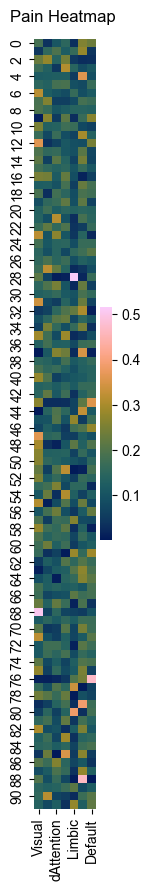

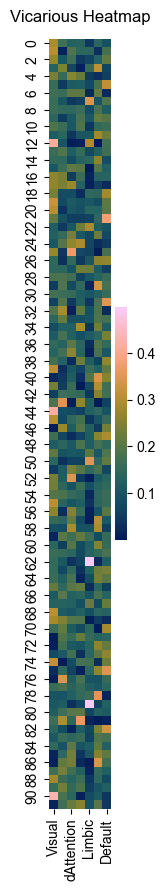

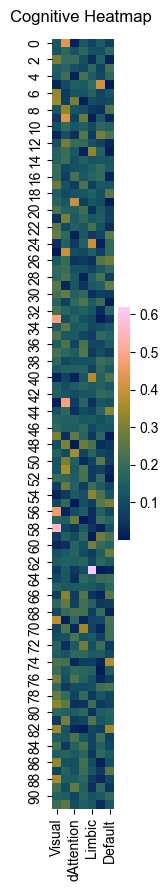

In [232]:

# Selecting the first 7 columns (which are the categories to be used in the heatmap)
# data_for_heatmap = P_STIM_cue[['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default']]
proportions = np.abs(P_STIM_cue[categories]).div(np.abs(P_STIM_cue[categories]).sum(axis=1), axis=0)

# Create the heatmap using seaborn
plt.figure(figsize=(1, 10))
heatmap = sns.heatmap(proportions, annot=False, fmt=".2f", cmap=ccm.batlow)
heatmap.set_title('Pain Heatmap ', fontdict={'fontsize':12}, pad=12)
plt.show()

proportions = np.abs(V_STIM_cue[categories]).div(np.abs(V_STIM_cue[categories]).sum(axis=1), axis=0)

# Create the heatmap using seaborn
plt.figure(figsize=(1, 10))
heatmap = sns.heatmap(proportions, annot=False, fmt=".2f", cmap=ccm.batlow)
heatmap.set_title('Vicarious Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

proportions = np.abs(C_STIM_cue[categories]).div(np.abs(C_STIM_cue[categories]).sum(axis=1), axis=0)

# Create the heatmap using seaborn
plt.figure(figsize=(1, 10))
heatmap = sns.heatmap(proportions, annot=False, fmt=".2f", cmap=ccm.batlow)
heatmap.set_title('Cognitive Heatmap ', fontdict={'fontsize':12}, pad=12)
plt.show()

## 1 What is the distribution of the 7 networks for domain-specific cue effects?

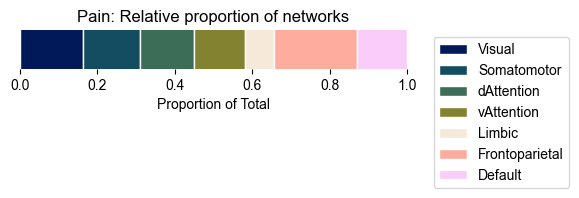

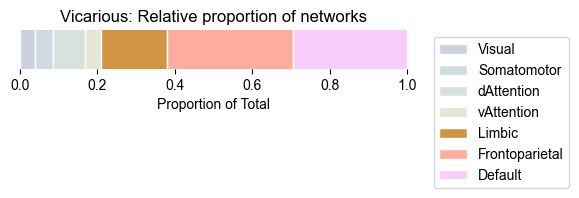

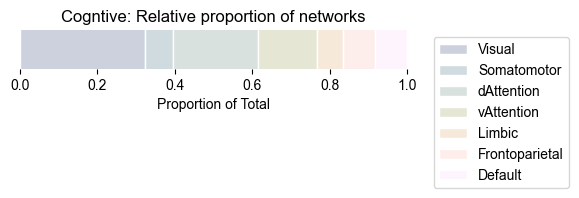

In [235]:
plot_group_avg_proportions(P_STIM_cue, 
                            categories=['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                            significance_mask=[1,1,1,1,0,1,1],
                            colormap=ccm.batlow,
                            figsize=(5,.5),
                            title="Pain: Relative proportion of networks") 
plot_group_avg_proportions(V_STIM_cue, 
                            categories=['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                            significance_mask=[0,0,0,0,1,1,1],
                            colormap=ccm.batlow,figsize=(5,.5),
                            title="Vicarious: Relative proportion of networks")   
c = plot_group_avg_proportions(C_STIM_cue, 
                            categories=['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                            significance_mask=[0,0,0,0,0,0,0],
                            colormap=ccm.batlow,figsize=(5,.5),
                            title="Cogntive: Relative proportion of networks") 


In [227]:
c.savefig('/Users/h/Desktop/TEST.png')

AttributeError: 'NoneType' object has no attribute 'savefig'

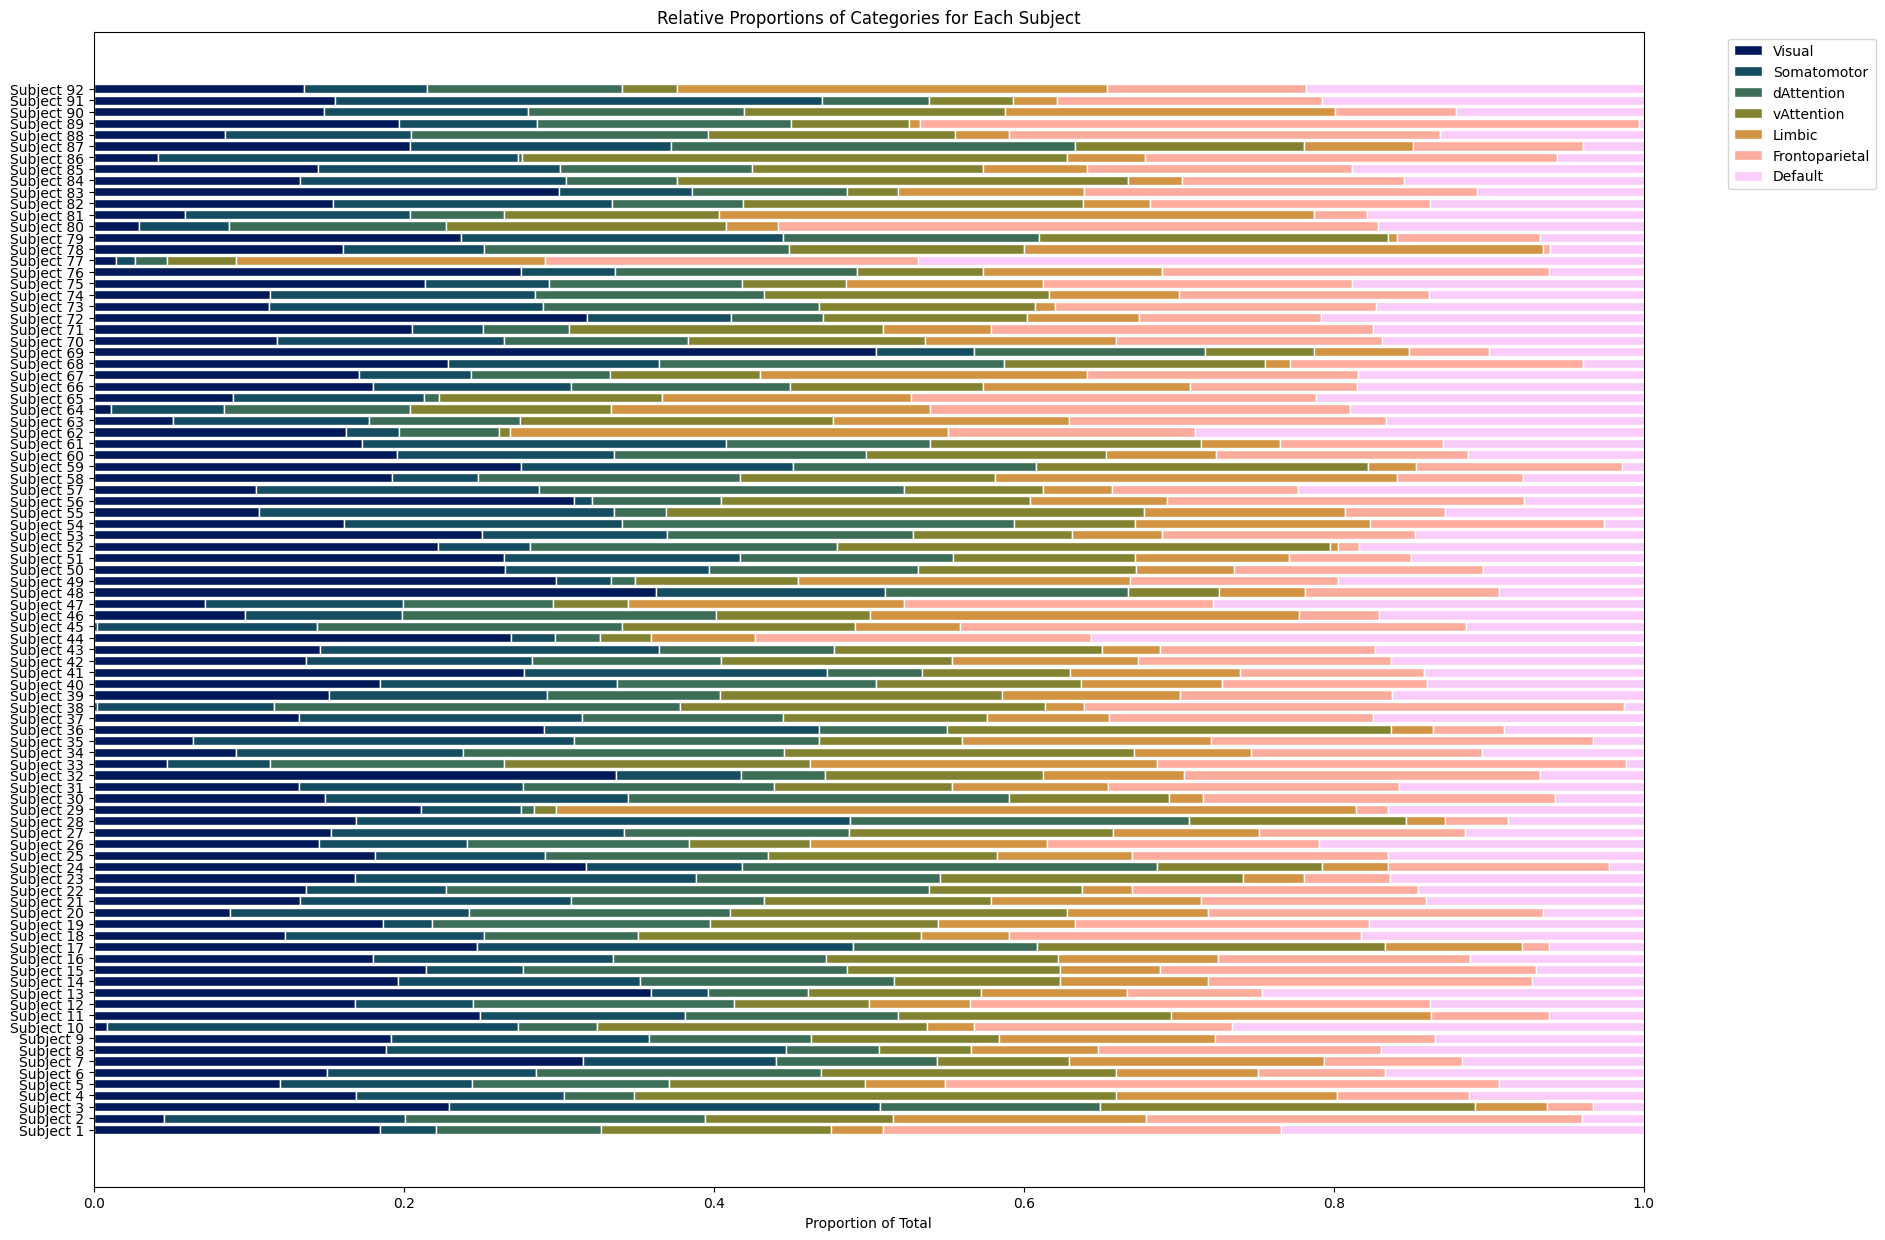

In [44]:
# Since I don't have the actual 'P_STIM_cue' DataFrame, I'll use the previously created DataFrame 'df'
# and assume it has the same structure for this example. The following code will plot a bar for each row
# in the DataFrame, showing the proportion of the 7 categories for that row.
categories = ['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default']
plt.figure(figsize=(20, 15))
batlow_colors = ccm.batlow(np.linspace(0, 1, len(categories)))
# Use a colormap that gives us 7 distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, 7))

# Go through each row and plot the proportions
for idx, row in P_STIM_cue.iloc[:, :7].iterrows():
    # Calculate the proportion of each category in the row
    row_proportions = np.abs(row) / np.sum(np.abs(row))
    # Plot each category proportion on top of the previous
    previous_value = 0
    for i, prop in enumerate(row_proportions):
        plt.barh(idx, prop, color=batlow_colors[i], left=previous_value, edgecolor='white')
        previous_value += prop
plt.xlim(0,1)
# Add legend
plt.legend(categories, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set labels and title
plt.xlabel('Proportion of Total')
plt.title('Relative Proportions of Categories for Each Subject')

# Set the y-axis to have one tick per subject
plt.yticks(range(len(P_STIM_cue)), ['Subject ' + str(i+1) for i in range(len(P_STIM_cue))])

plt.show()


In [200]:
def plot_proportions_sorted_outside(dataframe, categories, colormap, figsize=(10, 15)):
    """
    Plot a bar chart of proportions of categories for each row in the dataframe, sorted by the proportion of the first category.

    Parameters:
    - dataframe: pd.DataFrame containing the data to plot.
    - categories: List of categories (columns in the dataframe) to plot.
    - colormap: A matplotlib colormap to use for different categories.
    - figsize: Tuple indicating the figure size.
    """
    # Calculate proportions outside the loop
    # proportions = dataframe[categories].div(dataframe[categories].sum(axis=1), axis=0)
    
    # Sort the proportions based on the first category's proportion
    # proportions_sorted = proportions.sort_values(by=categories[0], ascending=False)

    plt.figure(figsize=figsize)
    
    # Generate colors from the provided colormap
    colors = colormap(np.linspace(0, 1, len(categories)))
    
    # Plot the sorted proportions for each subject
    for idx, row in dataframe.iterrows():
        previous_value = 0
        for i, prop in enumerate(row):
            plt.barh(idx, prop, color=colors[i], left=previous_value, edgecolor='white')
            previous_value += prop
    
    # Set plot parameters
    plt.xlim(0, 1)
    plt.legend(categories, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Proportion of Total')
    plt.title(f'Relative Proportions of Categories for Each Subject (Sorted by Proportion of {categories[0]})')
    # plt.yticks(range(len(dataframe)), ['Subject ' + str(i+1) for i in dataframe.index])

    plt.show()


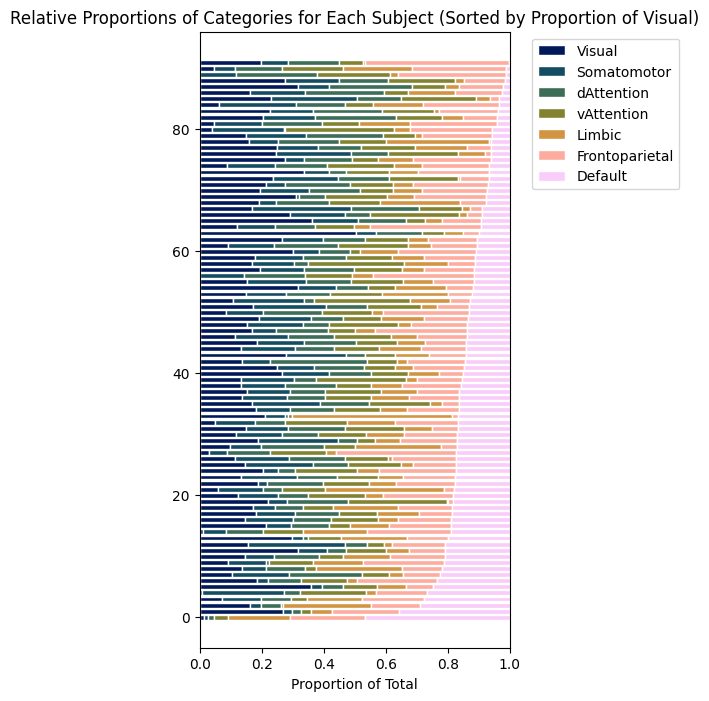

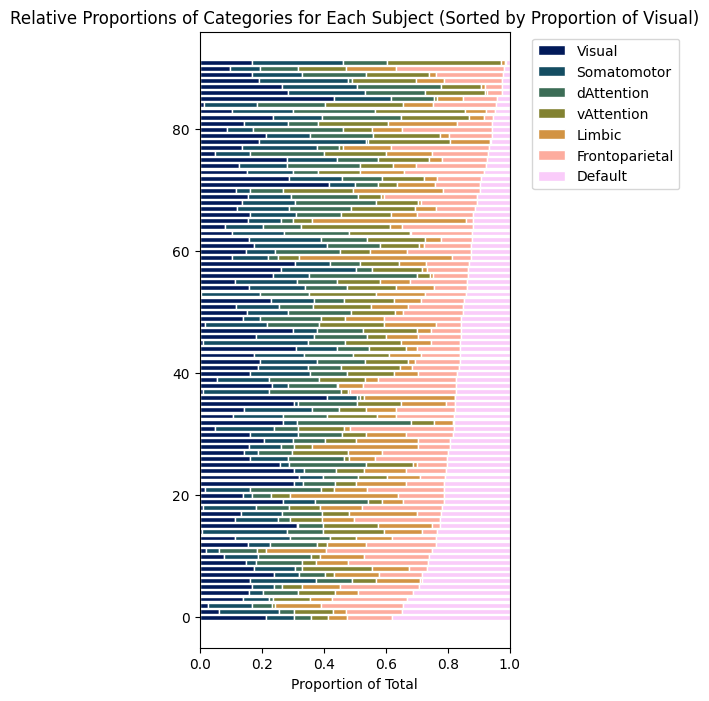

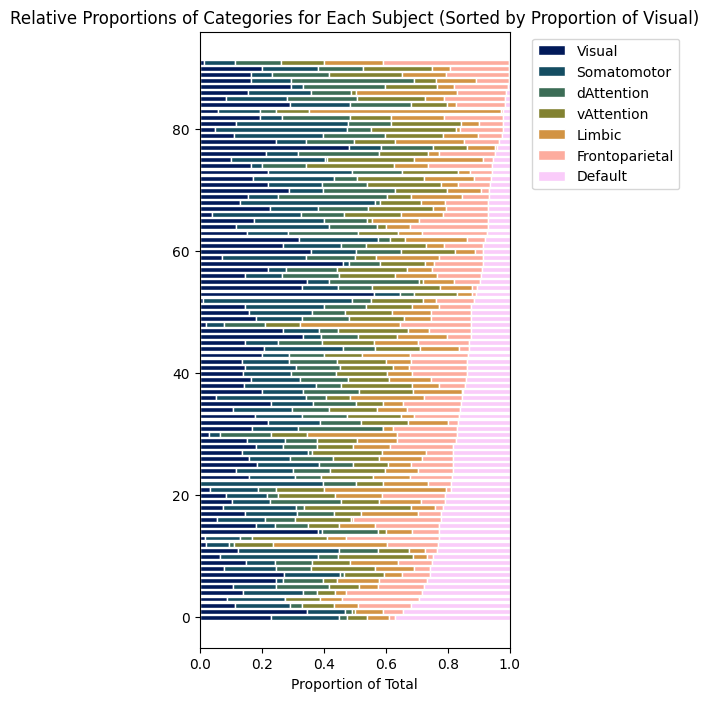

In [204]:

proportions = np.abs(P_STIM_cue[categories]).div(np.abs(P_STIM_cue[categories]).sum(axis=1), axis=0)
proportions_sorted = proportions.sort_values(by='Default', ascending=False)
proportions_sorted = proportions_sorted.reset_index(drop=True)

plot_proportions_sorted_outside(proportions_sorted, 
                                categories=['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                                colormap=ccm.batlow,
                                figsize=(4,8)) 

Vproportions = np.abs(V_STIM_cue[categories]).div(np.abs(V_STIM_cue[categories]).sum(axis=1), axis=0)
Vproportions_sorted = Vproportions.sort_values(by='Default', ascending=False)
Vproportions_sorted = Vproportions_sorted.reset_index(drop=True)

plot_proportions_sorted_outside(Vproportions_sorted, 
                                categories=['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                                colormap=ccm.batlow,
                                figsize=(4,8)) 

Cproportions = np.abs(C_STIM_cue[categories]).div(np.abs(C_STIM_cue[categories]).sum(axis=1), axis=0)
Cproportions_sorted = Cproportions.sort_values(by='Default', ascending=False)
Cproportions_sorted = Cproportions_sorted.reset_index(drop=True)

plot_proportions_sorted_outside(Cproportions_sorted, 
                                categories=['Visual', 'Somatomotor', 'dAttention', 'vAttention', 'Limbic', 'Frontoparietal', 'Default'], 
                                colormap=ccm.batlow,
                                figsize=(4,8)) 
